#Lesson 2: Computer Vision Fundamentals
## Submission, Markus Schwickert, 2018-02-22



In [28]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    plt.imshow(image)
    plt.show()
    return (image)

In [31]:
white_output = 'MS_videos/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip2))

Here comes the single image stuff

In [ ]:
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')



In [3]:
# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]

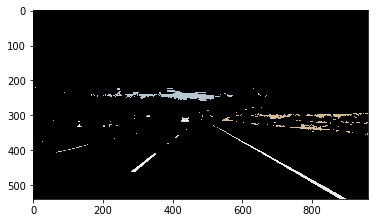

In [4]:
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

# Define our color selection criteria
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz
red_threshold = 180
green_threshold = 180
blue_threshold = 100
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)
plt.show()

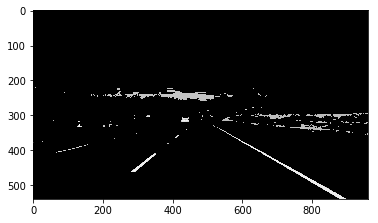

In [5]:
gray = cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

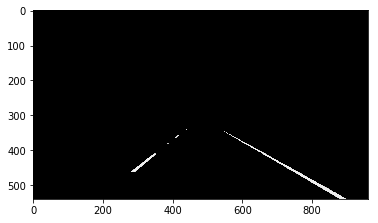

In [6]:
# Define a polygon region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing

left_bottom = [0, ysize]
right_bottom = [xsize, ysize]
fp1 = [450, 320]
fp2 = [490, 320]

mask = np.zeros_like(gray)   
ignore_mask_color = 255 

# This time we are defining a four sided polygon to mask
vertices = np.array([[left_bottom, fp1, fp2, right_bottom]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
grayROI = cv2.bitwise_and(gray, mask)

# Display the image
plt.imshow(grayROI, cmap='gray')

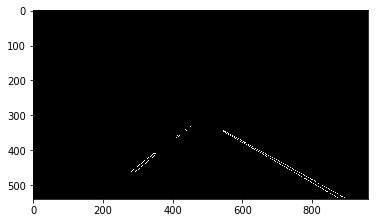

In [7]:
# Canny edge detection

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(grayROI,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')

solidWhiteCurve.jpg


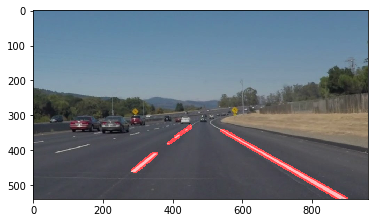

In [8]:
# Hough Transformation

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 16
max_line_gap = 20
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
print (test_images[k1])
combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(combo)

In [9]:
mpimg.imsave('MS_images/'+test_images[k1], combo)